In [450]:
%load_ext autoreload
%autoreload 2
%load_ext heat
%reload_ext heat
from repeater import WaldhauserRepeaterCatalog
from earthquake import EarthquakeCatalog
import copy
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The heat extension is already loaded. To reload it, use:
  %reload_ext heat


Todo:

why does NEV not match len(families)

In [451]:
mpl.rc('figure', dpi=200)

In [452]:
repeaters = WaldhauserRepeaterCatalog()

In [453]:
data_directory = Path('data/earthquake_catalogs/')
earthquake_metadata = {
    "starttime": '1990-01-01',
    "endtime": '2024-01-01',
    "latitude_range": [-90,90],
    "longitude_range": [-180,180],
    "minimum_magnitude": 1, 
} 

earthquakes = EarthquakeCatalog(
    filename=data_directory/'global_ALL.csv',
    kwargs=earthquake_metadata,
) # expect warnings about loading existing catalog and Nan values

/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/earthquake.py:176: UserWarning: Using existing data/earthquake_catalogs/global_ALL.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/earthquake.py:182: UserWarning: 27913 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


Text(0.5, 1.0, 'Example repeaters')

/Users/kdascher/miniforge3/envs/eq_stats/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


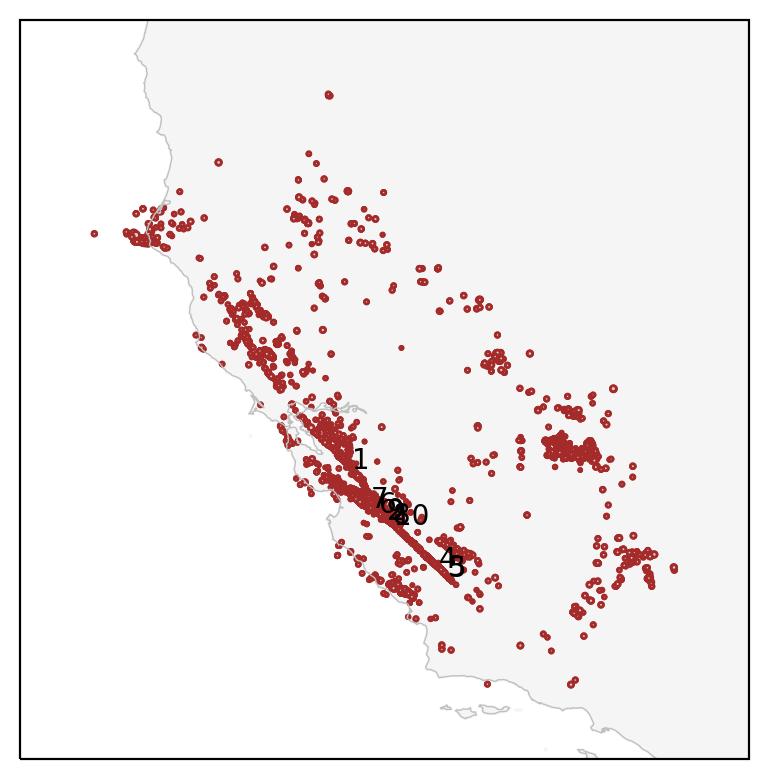

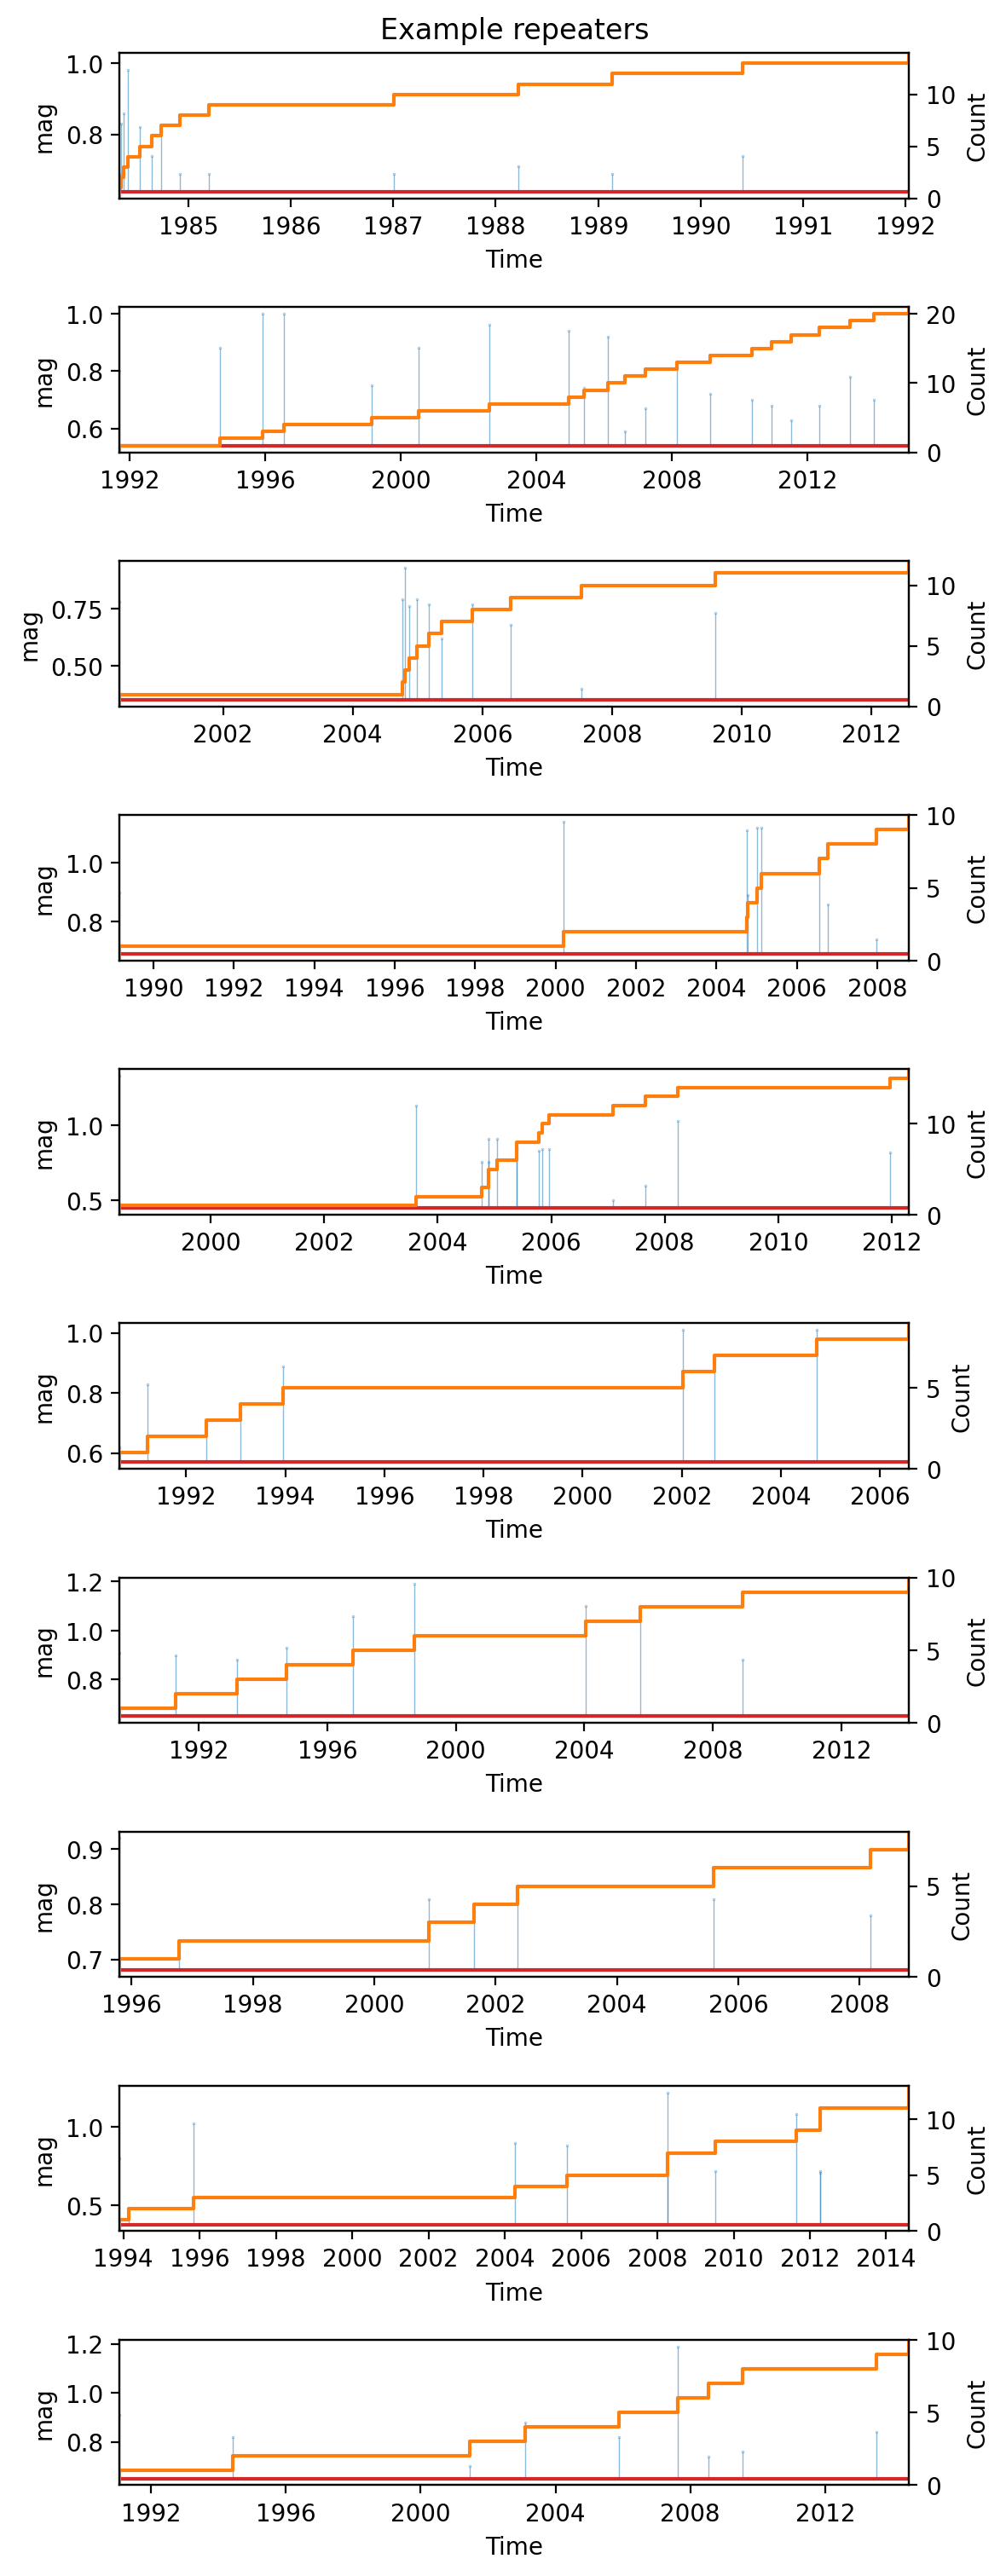

In [795]:
number_of_examples = 10

ax = repeaters.plot_map()
for i in range(number_of_examples):
    i_lat = repeaters.catalog.loc[repeaters.catalog.family==i].lat.mean()
    i_lon = repeaters.catalog.loc[repeaters.catalog.family==i].lon.mean()
    ax.text(i_lon, i_lat, f'{i+1}')

fig, AX = plt.subplots(number_of_examples,1, figsize=(6,15))
for i, ax in enumerate(AX):
    new = copy.deepcopy(repeaters)
    new.catalog = new.catalog.loc[new.catalog.family==i]
    new.__update__()
    new.plot_time_series(ax=ax)
    
plt.tight_layout()
AX[0].set_title('Example repeaters')

## Refine repeaters according to the following criteria

NEV: Number of events in sequence

LATm/LONm/DEPm: Median location of all events in sequence

MAGm/MAGs: Median/standard deviation of NCSN magntiudes

DMAGm/DMAGs: Median/standard deviation of differential (corr-based) magnitudes

RCm/RCs/RCcv: Median/standard deviation/coefficient of variation of recurrence times for all RE

RCm1/RCs1/RCcv1: Median/standard deviation/coefficient of variation of recurrence times for quasi-period sequences (RESp)
                   
CCm: Median of all long window correlation coefficients across all stations and events


In [797]:
minimum_number_of_events = 3
max_coefficient_of_variation = 0.3    # regular 
minimum_avg_repeater_magnitude = 1.5  # large-ish
maximum_location_error = 100         # m accurately located 

repeaters_clean = copy.deepcopy(repeaters)

repeaters_clean.catalog = repeaters_clean.catalog.loc[
    repeaters_clean.catalog["NEV"] > minimum_number_of_events
]
repeaters_clean.catalog = repeaters_clean.catalog.loc[
    repeaters_clean.catalog["RCcv1"] < max_coefficient_of_variation
]
repeaters_clean = repeaters_clean.get_space_slice(
    latitude_range=(35.0, 36.5), longitude_range=repeaters_clean.longitude_range
)

for family in repeaters_clean.catalog.family:
    
    if (
        repeaters_clean.catalog.loc[repeaters_clean.catalog.family == family].mag.mean()
        < minimum_avg_repeater_magnitude
    ):
        repeaters_clean.catalog = repeaters_clean.catalog.loc[
            repeaters_clean.catalog.family != family
        ]
    
    elif (
        repeaters_clean.catalog.loc[repeaters_clean.catalog.family == family].EZ.min()
        > maximum_location_error
    ):
        repeaters_clean.catalog = repeaters_clean.catalog.loc[
            repeaters_clean.catalog.family != family
        ]

repeaters_clean.__update__()

# repeaters_clean.mag_completeness = 2.5

nearby_earthquakes = earthquakes.intersection(
    repeaters_clean, buffer_radius_km=10
).slice_by("mag", 3.5, 10)

/Users/kdascher/miniforge3/envs/eq_stats/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


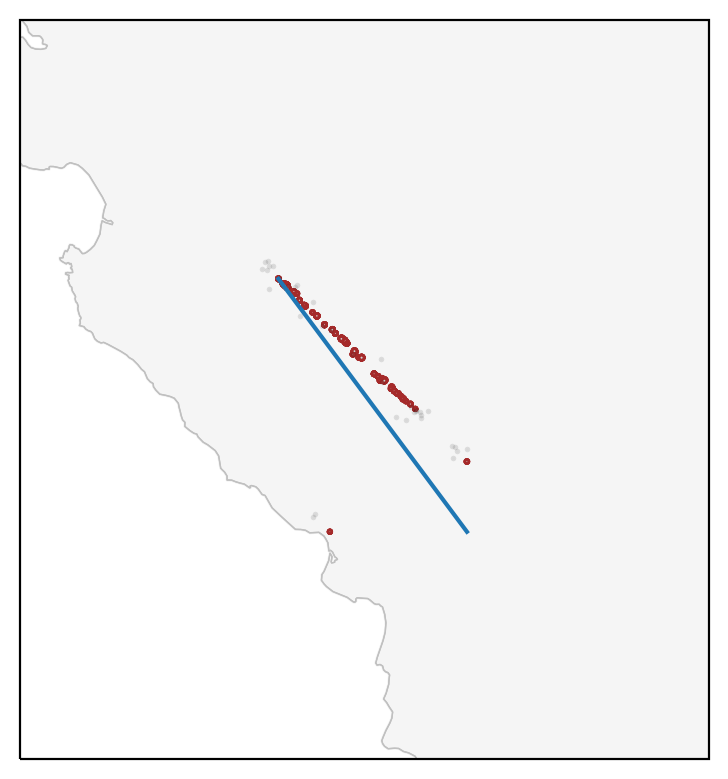

In [798]:
ax = repeaters_clean.plot_map()

p1 = (repeaters_clean.longitude_range[0],repeaters_clean.latitude_range[1])
p2 = (repeaters_clean.longitude_range[1],repeaters_clean.latitude_range[0])

nearby_earthquakes.plot_map(ax=ax, scatter_kwarg=dict(edgecolor='k',s=1, alpha=0.1))
ax.plot([p1[0],p2[0]],[p1[1],p2[1]])


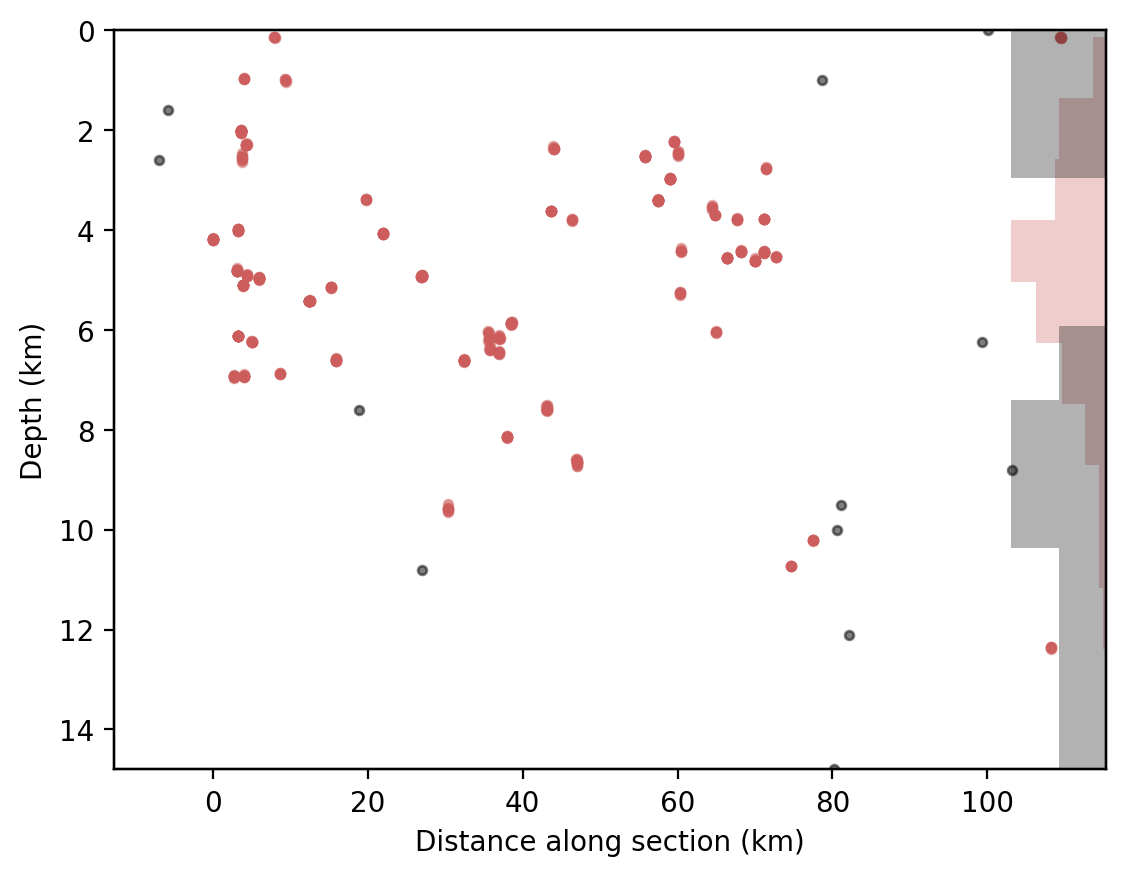

In [799]:
fig, ax = plt.subplots()
repeaters_clean.plot_depth_cross_section(
    p1=p1,
    p2=p2,
    ax=ax,
    kwargs=dict(c='indianred', s=10),
)

nearby_earthquakes.slice_by('mag',4).plot_depth_cross_section(
    p1=p1,
    p2=p2,
    kwargs=dict(c='k', s=10),
    ax=ax,
);


Text(0.5, 1.0, 'Example repeaters')

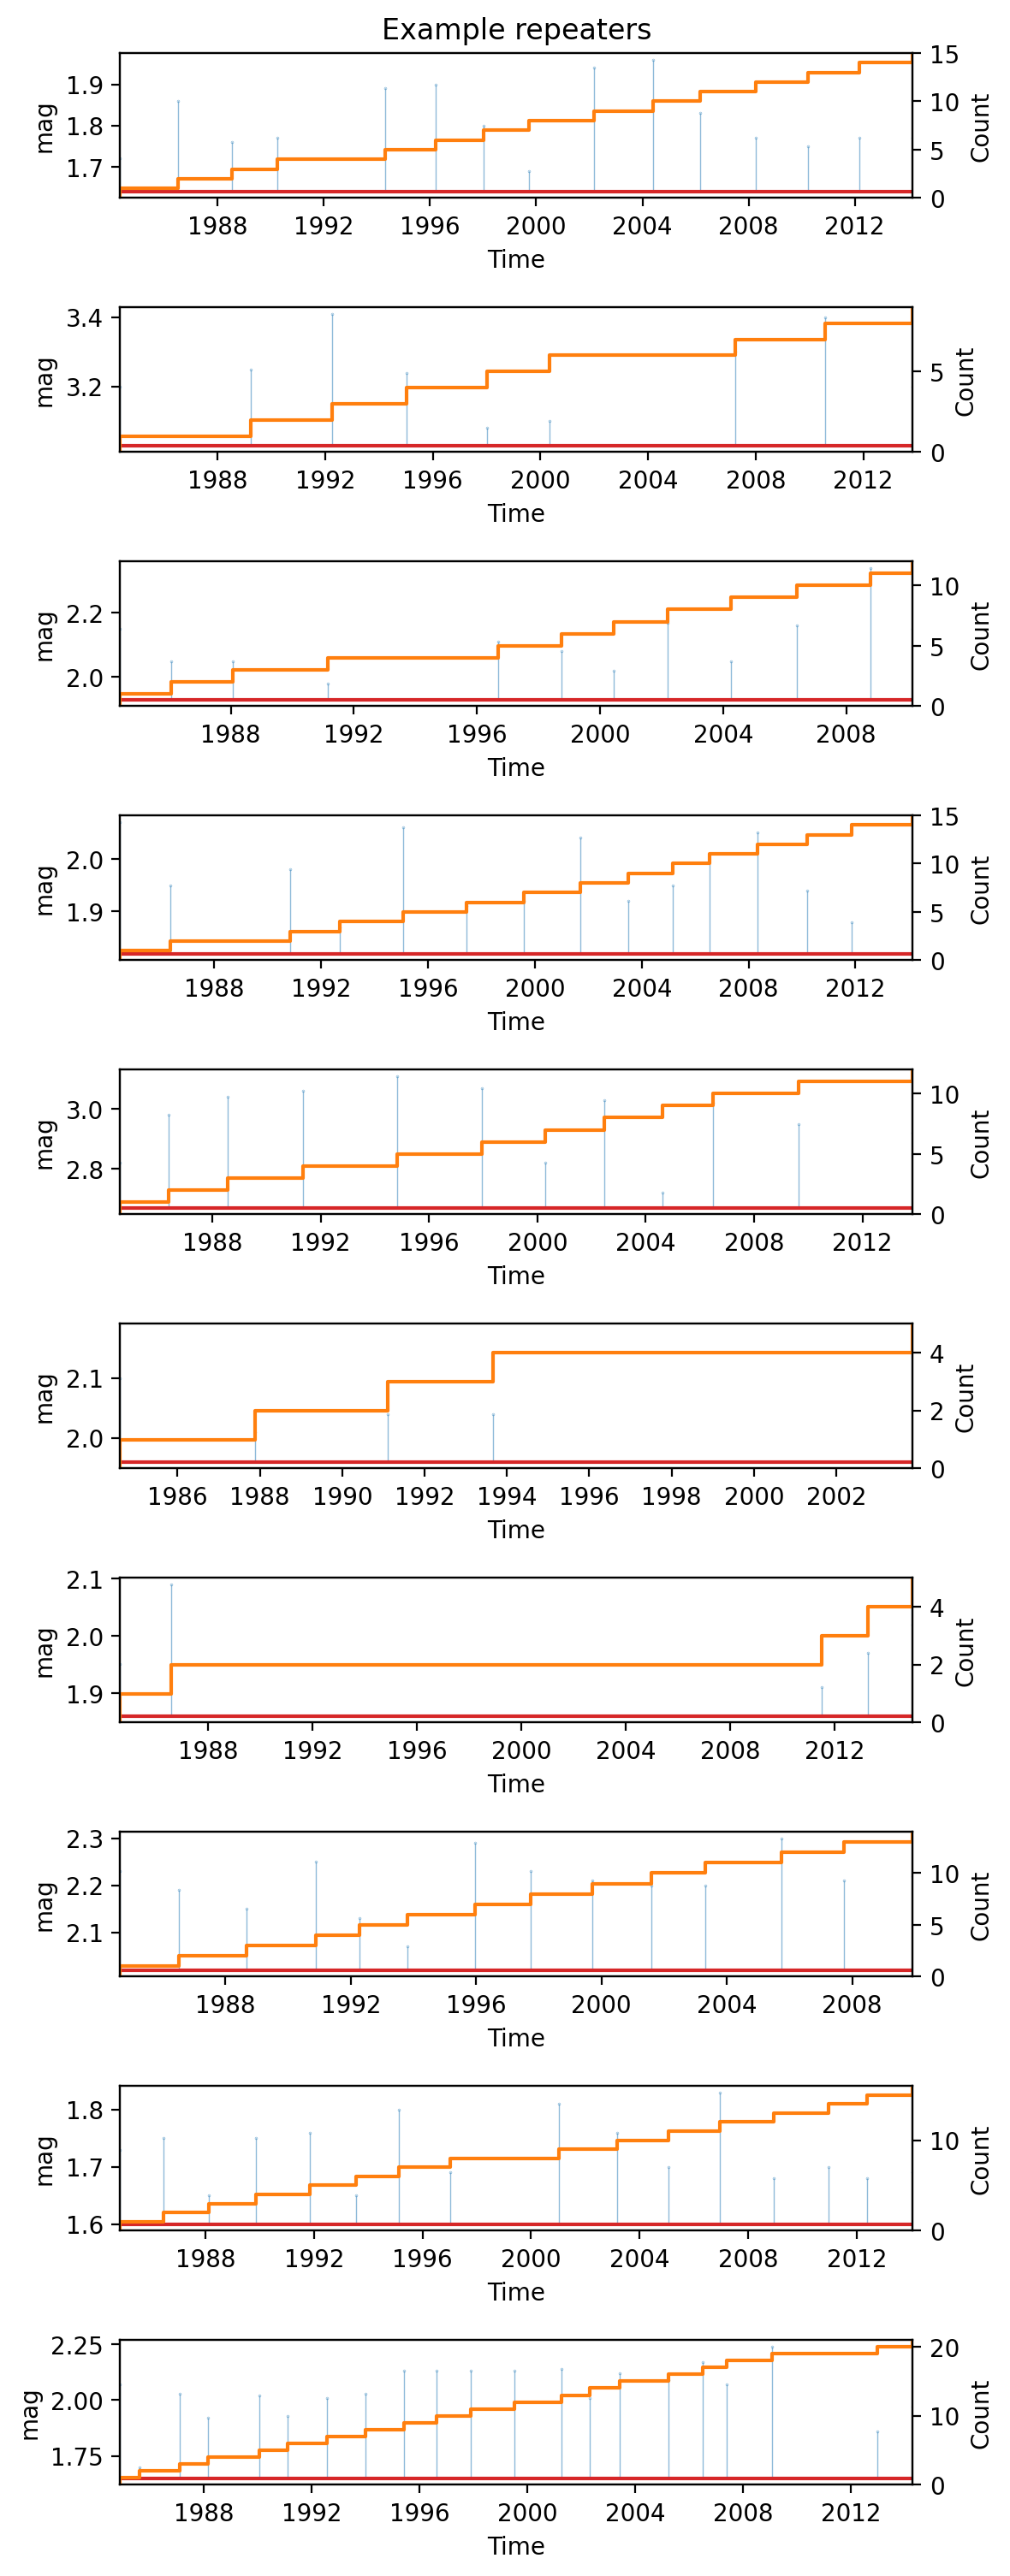

In [800]:
fig, AX = plt.subplots(10,1, figsize=(6,15))
family = repeaters_clean.catalog.family.unique()

for i, ax in enumerate(AX):
    new = copy.deepcopy(repeaters_clean)
    new.catalog = new.catalog.loc[new.catalog.family==family[i]]
    new.start_time = new.catalog.time.min()
    new.end_time = new.catalog.time.max()
    new.plot_time_series(ax=ax)
    
plt.tight_layout()
AX[0].set_title('Example repeaters')

In [801]:
families = repeaters_clean.get_families()

In [802]:
minimum_number_of_overlapping_events = 3

delta_M = []
max_M = []

distance = []

delta_recurrence_interval = []
max_reccurence_interval = []

COV = []

ij_list = []


for i, i_family in enumerate(families):

    for j, j_family in enumerate(families[:i]):

        t1 = max(i_family.start_time, j_family.start_time)
        t2 = min(i_family.end_time, j_family.end_time)

        if t1 < t2:

            Ni = ((i_family.catalog.time > t1) & (i_family.catalog.time < t2)).sum()
            Nj = ((j_family.catalog.time > t1) & (j_family.catalog.time < t2)).sum()

            if (
                Ni > minimum_number_of_overlapping_events
                and Nj > minimum_number_of_overlapping_events
            ):

                # difference in median magnitude
                delta_M.append(
                    np.abs(i_family.catalog.mag.mean() - j_family.catalog.mag.mean())
                )

                max_M.append(
                    max(i_family.catalog.mag.mean(), j_family.catalog.mag.mean())
                )

                # distance: dumb way to do this but whatever:
                distance.append(
                    np.median(
                        np.concatenate(
                            i_family.get_neighboring_indices(
                                j_family, buffer_radius_km=1e10, return_distances=True
                            )[1]
                        )
                    )
                )

                # difference in recurrence interval:
                delta_recurrence_interval.append(
                    np.abs(
                        i_family.catalog.RCm.values[0] - j_family.catalog.RCm.values[0]
                    )
                )

                max_reccurence_interval.append(
                    max(i_family.catalog.RCm.values[0], j_family.catalog.RCm.values[0])
                )

                COV.append(
                    np.mean(
                        [
                            i_family.catalog.RCcv.values[0],
                            j_family.catalog.RCcv.values[0],
                        ]
                    )
                )

                ij_list.append([i, j])

delta_M = np.array(delta_M)
max_M = np.array(max_M)
distance = np.array(distance)
delta_recurrence_interval = np.array(delta_recurrence_interval)
max_reccurence_interval = np.array(max_reccurence_interval)
COV = np.array(COV)

In [803]:
def Mw_to_Mo(Mw):
    return 10**(3/2 * Mw + 9.05)

def Mw_to_length_scale(M, stress_drop=3*10**6):
    M0 = Mw_to_Mo(M)
    return (7/2 * M0 / stress_drop)**(1/3)
 

[None,
 Text(0, 0.5, 'Distance \n # of Source dimension'),
 Text(0.5, 0, 'percent difference in recurrence interval\nrelative to max')]

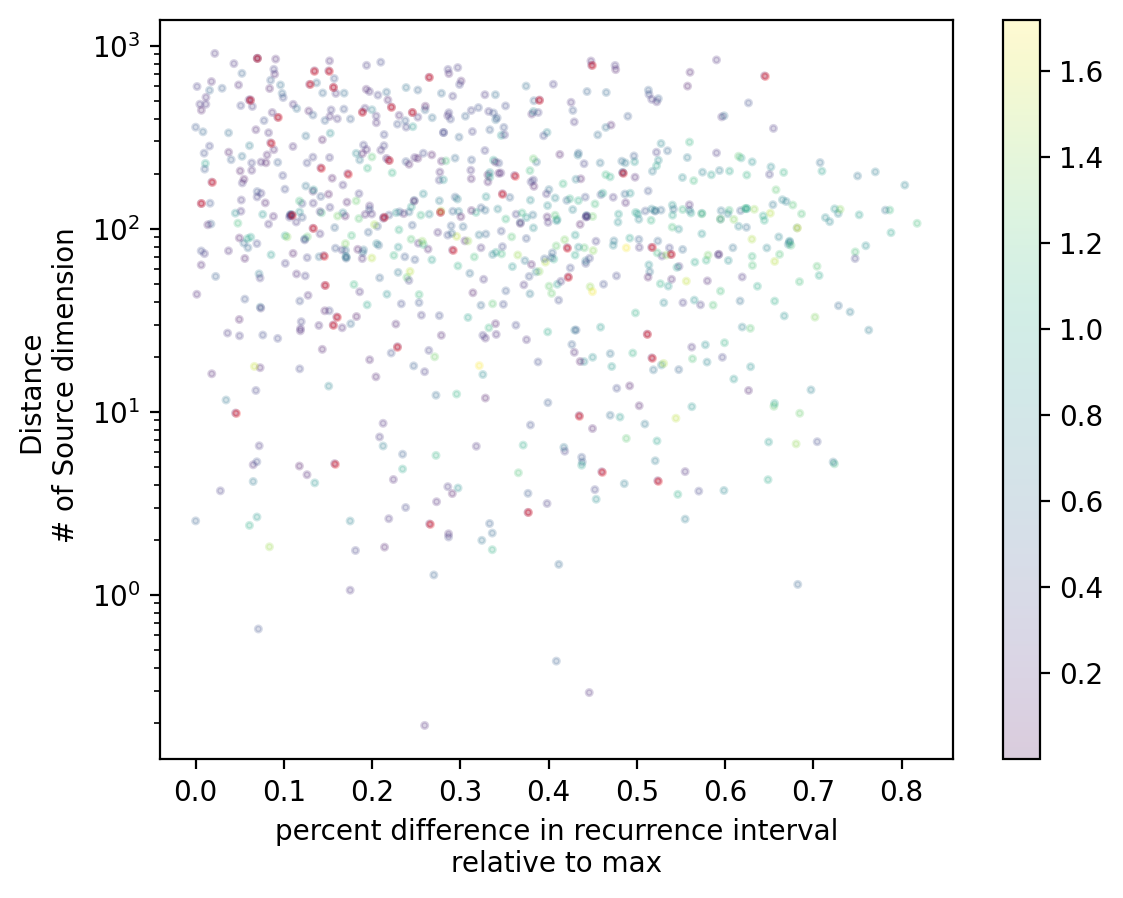

In [804]:
fig, ax = plt.subplots()
sc = ax.scatter(
    delta_recurrence_interval / max_reccurence_interval,
    distance*1000 /  Mw_to_length_scale(max_M),
    c=delta_M,
    alpha=0.2,
    s=5,
)

threshold_difference_in_period = 0.05

I = delta_M<threshold_difference_in_period
ax.scatter(
    delta_recurrence_interval[I]/ max_reccurence_interval[I],
    distance[I]*1000 / Mw_to_length_scale(max_M[I]),
    c='r',
    alpha=0.2,
    s=5
)

fig.colorbar(sc)

ax.set(
    yscale="log",
    ylabel="Distance \n # of Source dimension",
    xlabel="percent difference in recurrence interval\nrelative to max",
)

[Text(0.5, 0, 'distance'), Text(0, 0.5, 'delta M'), None]

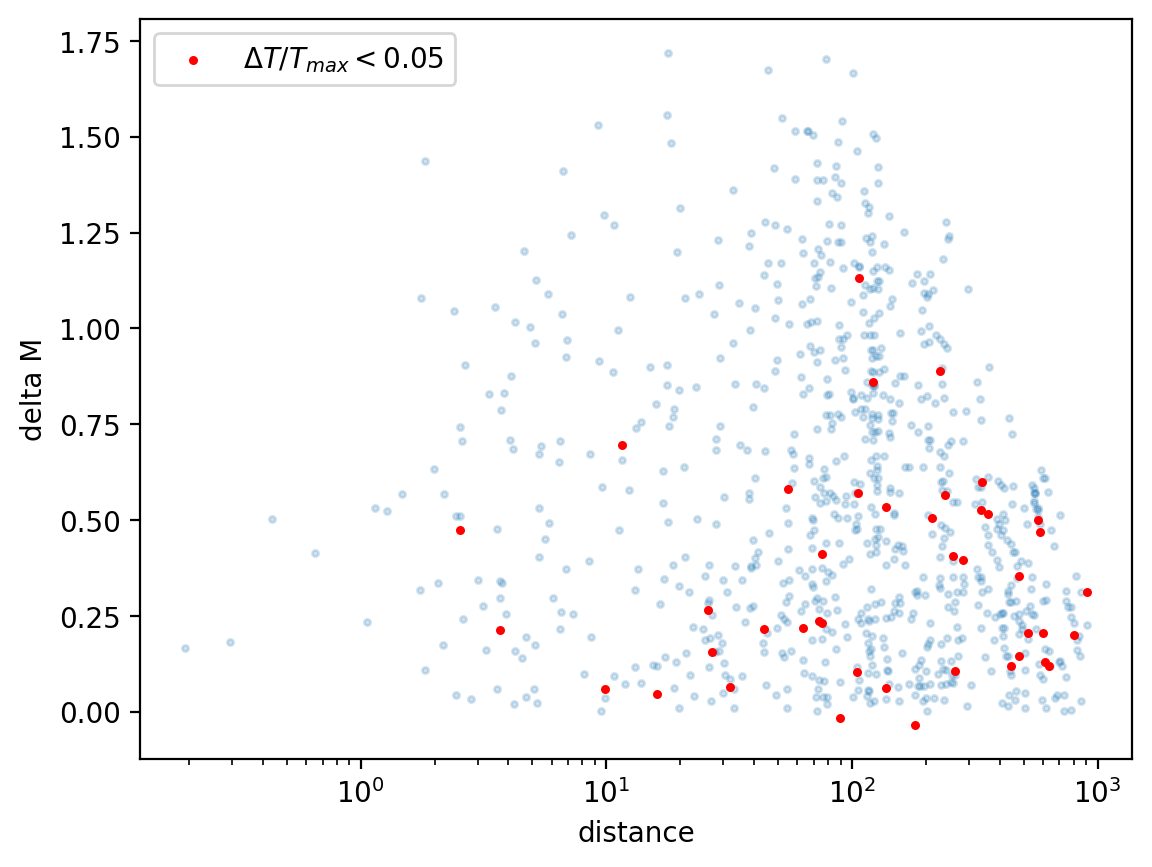

In [805]:
fig, ax = plt.subplots()

sc = ax.scatter(
    distance*1000 / Mw_to_length_scale(max_M), # proxy for strenght of attraction 
    delta_M, # proxy for base phase difference 
    alpha=0.2,
    s=5,
)

I = delta_recurrence_interval / max_reccurence_interval < threshold_difference_in_period
ax.scatter(
    distance[I]*1000 / Mw_to_length_scale(max_M[I]), # proxy for strenght of attraction 
    delta_M[I]+np.random.uniform(-0.1,0.1,sum(I)), # proxy for base phase difference 
    c='r',
    s=5,
    label=r"$\Delta T/T_{max} <$" + f"{threshold_difference_in_period}",
)

ax.legend()

ax.set(xlabel="distance", ylabel="delta M", xscale='log')

In [834]:
selected = np.argsort(distance)[2]

[Text(0, 0.5, 'Cummulative\nmoment\ndeficit')]

/Users/kdascher/miniforge3/envs/eq_stats/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


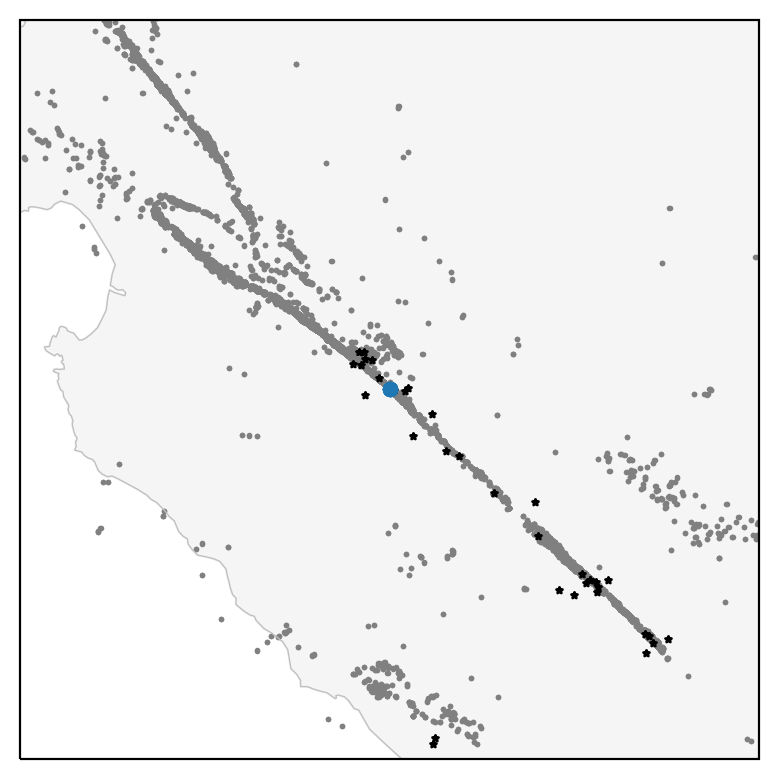

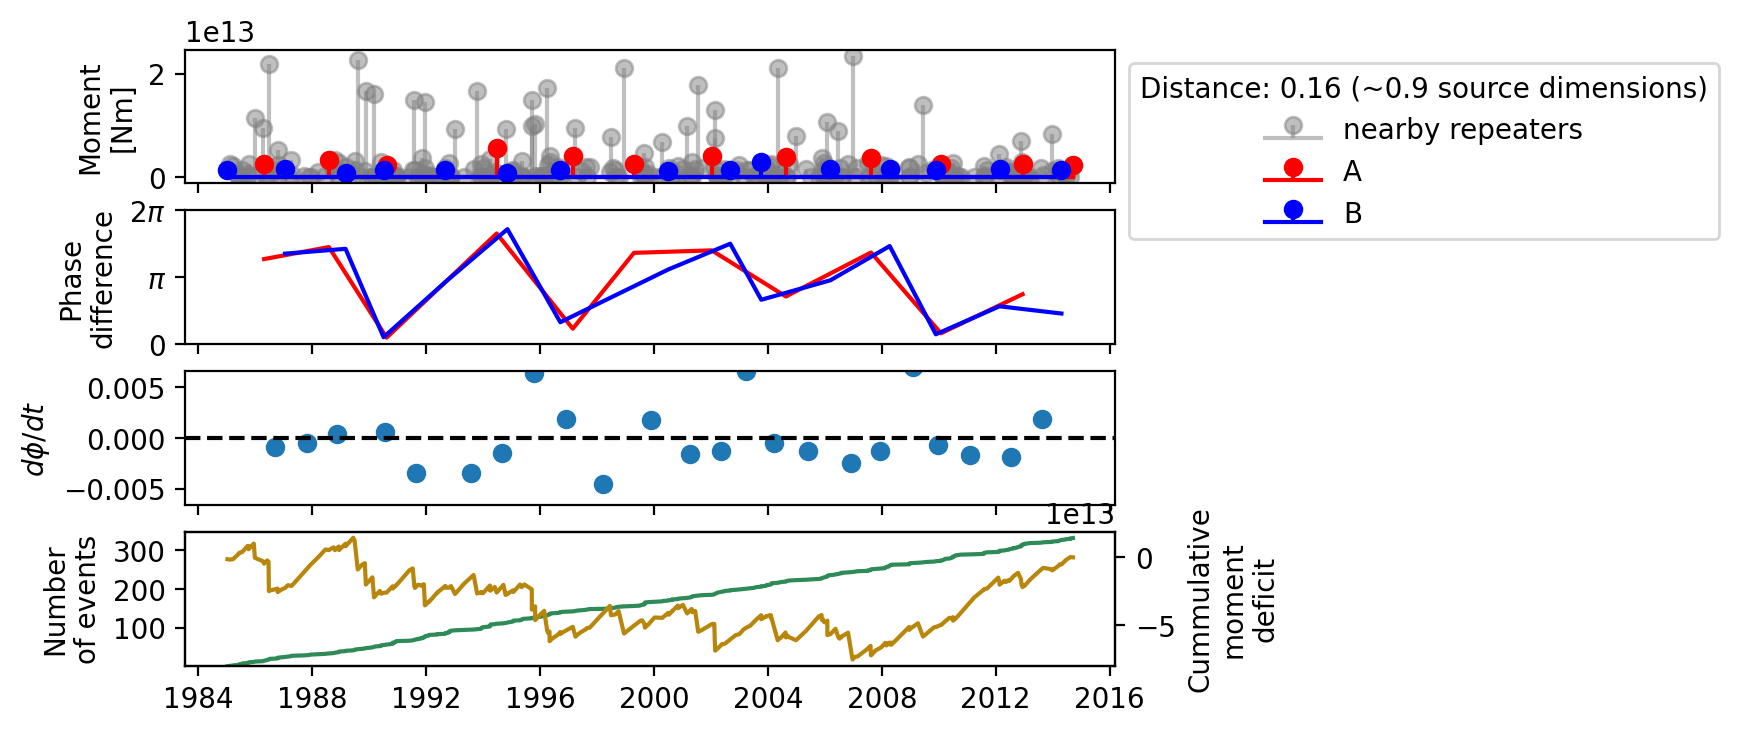

In [835]:
# selected = np.argsort(
#     distance
#     /
#     np.mean([
#         Mw_to_length_scale(max_M), Mw_to_length_scale(max_M-delta_M)
#     ])
# )[2]


ij_selected = ij_list[selected]

ax = families[ij_selected[0]].plot_map()
earthquakes.intersection(repeaters_clean, buffer_radius_km=10).slice_by("mag", 4, 10)

ax.scatter(repeaters.catalog.lon, repeaters.catalog.lat, s=1, c="grey")
ax.scatter(
    nearby_earthquakes.catalog.lon,
    nearby_earthquakes.catalog.lat,
    s=5,
    c="k",
    marker="*",
)

ax.scatter(
    families[ij_selected[1]].catalog.lon, families[ij_selected[1]].catalog.lat, s=20
)

# ax.set_extent(np.array(ax.get_extent()-)

fig, [ax, ax1, ax1b, ax2] = plt.subplots(4, 1, figsize=(6, 4), sharex=True)

very_nearby_earthquakes = nearby_earthquakes.intersection(
    families[ij_selected[0]], buffer_radius_km=distance[selected]
).get_time_slice(
    min(families[ij_selected[0]].start_time, families[ij_selected[1]].start_time),
    max(families[ij_selected[0]].end_time, families[ij_selected[1]].end_time),
)

if len(very_nearby_earthquakes) > 0:
    stem_3 = ax.stem(
        very_nearby_earthquakes.catalog.time,
        Mw_to_Mo(very_nearby_earthquakes.catalog.mag),
        label="nearby earthquakes",
    )
    plt.setp(stem_3, color="k")

very_nearby_repeaters = repeaters.intersection(
    families[ij_selected[0]], buffer_radius_km=distance[selected] * 5
).get_time_slice(
    min(families[ij_selected[0]].start_time, families[ij_selected[1]].start_time),
    max(families[ij_selected[0]].end_time, families[ij_selected[1]].end_time),
)
if len(very_nearby_repeaters) > 0:
    stem_4 = ax.stem(
        very_nearby_repeaters.catalog.time,
        Mw_to_Mo(very_nearby_repeaters.catalog.mag),
        label="nearby repeaters",
    )
    plt.setp(stem_4, color="grey", alpha=0.5)

stem_1 = ax.stem(
    families[ij_selected[0]].catalog.time,
    Mw_to_Mo(families[ij_selected[0]].catalog.mag),
    label="A",
)
stem_2 = ax.stem(
    families[ij_selected[1]].catalog.time,
    Mw_to_Mo(families[ij_selected[1]].catalog.mag),
    label="B",
)
plt.setp(stem_1, color="r")
plt.setp(stem_2, color="b")

ax.set(ylabel="Moment\n[Nm]")

lg = ax.legend(bbox_to_anchor=[1, 1])
SD = (
    distance[selected]
    * 1000
    / Mw_to_length_scale(
        max(
            [
                families[ij_selected[0]].catalog.mag.max(),
                families[ij_selected[1]].catalog.mag.max(),
            ]
        )
    )
)

lg.set_title(f"Distance: {distance[selected]:0.2f} (~{SD:0.1f} source dimensions)")


###
def get_phase(tq, t: np.ndarray):
    # note: not vectorized

    if tq < min(t) or tq > max(t):
        return np.NaN

    dt = (t - tq) / np.timedelta64(1, "D")

    dt_pos = dt[dt > 0]
    dt_neg = dt[dt < 0]

    t1 = min(-dt_neg)
    t2 = min(dt_pos)

    T = t1 + t2

    phase = 2 * np.pi * t1 / T

    return phase


def get_phase_time_series(tq, t):
    return np.array([get_phase(itq, t) for itq in tq])


phase_A = get_phase_time_series(
    families[ij_selected[0]].catalog.time, families[ij_selected[1]].catalog.time
)

phase_B = get_phase_time_series(
    families[ij_selected[1]].catalog.time, families[ij_selected[0]].catalog.time
)

ax1.plot(families[ij_selected[0]].catalog.time, phase_A, c="r")
ax1.plot(families[ij_selected[1]].catalog.time, 2 * np.pi - phase_B, c="b")
ax1.set(
    yticks=[0, np.pi, 2 * np.pi],
    yticklabels=["0", r"$\pi$", r"$2\pi$"],
    ylabel="Phase\ndifference",
)

###

phase_measurement_times = np.concatenate([families[ij_selected[0]].catalog.time.values, families[ij_selected[1]].catalog.time.values])
phase = np.concatenate([2*np.pi-phase_A,phase_B])

sorted_indices = np.argsort(phase_measurement_times)
phase_measurement_times = phase_measurement_times[sorted_indices]
phase = phase[sorted_indices]

phase_measurement_times = phase_measurement_times[~np.isnan(phase)]
phase = phase[~np.isnan(phase)]

t_days = (phase_measurement_times - phase_measurement_times[0])/np.timedelta64(1,'D')
phase_diff_measurement_times = phase_measurement_times[0] + ((t_days[:-1] + t_days[1:])/2) * np.timedelta64(1,'D')

ax1b.scatter(phase_diff_measurement_times,np.diff(phase)/np.diff(t_days))
ax1b.axhline(0,c='k',ls='--')

ylim = 2*np.pi/np.median((np.diff(families[ij_selected[0]].catalog.time.values)/np.timedelta64(1,'D')))
ax1b.set(ylabel=r'$d\phi/dt$', ylim=[-ylim,ylim])

###

ax2.plot(
    very_nearby_repeaters.catalog.time,
    np.arange(len(very_nearby_repeaters)),
    color="seagreen",
)
ax2.set(ylabel="Number\nof events", ylim=[-0.1 * ax2.get_ylim()[0], ax2.get_ylim()[1]])

axb = ax2.twinx()
axb.plot(
    very_nearby_repeaters.catalog.time,
    -np.cumsum(Mw_to_Mo(very_nearby_repeaters.catalog.mag))
    + np.sum(Mw_to_Mo(very_nearby_repeaters.catalog.mag))
    / ((very_nearby_repeaters.catalog.time.values[-1] - very_nearby_repeaters.catalog.time.values[0])/np.timedelta64(1,'D'))
    * ((very_nearby_repeaters.catalog.time-very_nearby_repeaters.catalog.time.values[0])/np.timedelta64(1,'D')),
    color="darkgoldenrod",
)
axb.set(ylabel="Cummulative\nmoment\ndeficit")

[[<matplotlib.axis.XTick at 0x82dd4a860>,
 [Text(0.0, 0, '0'),
  Text(3.141592653589793, 0, '$\\pi$'),
  Text(6.283185307179586, 0, '$2\\pi$')],
 Text(0.5, 0, 'Phase difference')]

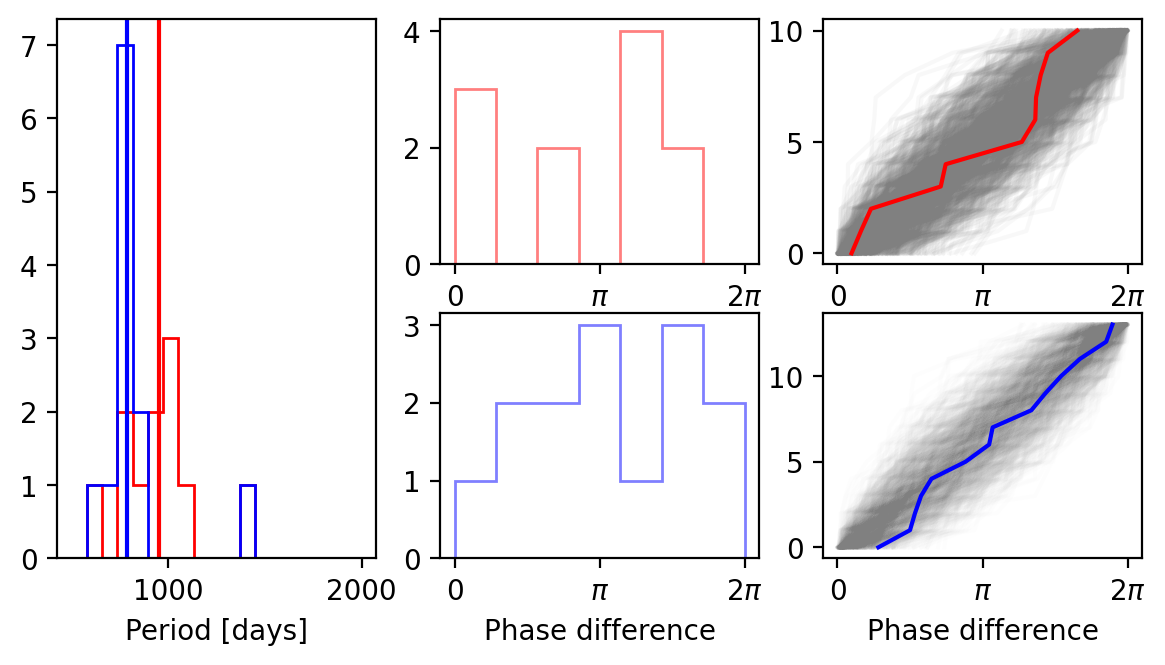

In [842]:
fig = plt.figure(figsize=(7,3.5))
gs = mpl.gridspec.GridSpec(2, 3)

ax = fig.add_subplot(gs[:, 0])
ax.hist(
    np.diff(families[ij_selected[0]].catalog.time) / np.timedelta64(1, "D"),
    bins=np.linspace(500, 2000, 20),
    histtype="step",
    color="r",
)
ax.hist(
    np.diff(families[ij_selected[1]].catalog.time) / np.timedelta64(1, "D"),
    bins=np.linspace(500, 2000, 20),
    histtype="step",
    color="b",
)

ax.axvline(
    np.median(np.diff(families[ij_selected[0]].catalog.time) / np.timedelta64(1, "D")),
    color="r",
)
ax.axvline(
    np.median(np.diff(families[ij_selected[1]].catalog.time) / np.timedelta64(1, "D")),
    color="b",
)
ax.set(xlabel="Period [days]")

ax1 = fig.add_subplot(gs[0, 1])
ax1.hist(
    phase_A, bins=np.linspace(0, 2 * np.pi, 8), histtype="step", color="r", alpha=0.5
)
ax1.set(
    xticks=[0, np.pi, 2 * np.pi],
    xticklabels=["0", r"$\pi$", r"$2\pi$"],
)

ax2 = fig.add_subplot(gs[1, 1])
ax2.hist(
    phase_B,
    bins=np.linspace(0, 2 * np.pi, 8),
    histtype="step",
    color="b",
    alpha=0.5,
)
ax2.set(
    xticks=[0, np.pi, 2 * np.pi],
    xticklabels=["0", r"$\pi$", r"$2\pi$"],
    xlabel="Phase difference",
)

number_of_samples = 1000

ax1b = fig.add_subplot(gs[0, 2])

phase_A_sorted = np.sort(phase_A[~np.isnan(phase_A)])

[
    ax1b.plot(
        np.sort(np.random.uniform(0, 2 * np.pi, len(phase_A_sorted))),
        np.arange(len(phase_A_sorted)),
        c="grey",
        alpha=0.05,
    )
    for _ in range(number_of_samples)
]
ax1b.plot(phase_A_sorted, np.arange(len(phase_A_sorted)), color="r")
ax1b.set(
    xticks=[0, np.pi, 2 * np.pi],
    xticklabels=["0", r"$\pi$", r"$2\pi$"],
)

ax1b = fig.add_subplot(gs[1, 2])

phase_B_sorted = np.sort(phase_B[~np.isnan(phase_B)])
[
    ax1b.plot(
        np.sort(np.random.uniform(0, 2 * np.pi, len(phase_B_sorted))),
        np.arange(len(phase_B_sorted)),
        c="grey",
        alpha=0.01,
    )
    for _ in range(number_of_samples)
]
ax1b.plot(phase_B_sorted, np.arange(len(phase_B_sorted)), color="b")
ax1b.set(
    xticks=[0, np.pi, 2 * np.pi],
    xticklabels=["0", r"$\pi$", r"$2\pi$"],
    xlabel="Phase difference",
)

/Users/kdascher/miniforge3/envs/eq_stats/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kdascher/miniforge3/envs/eq_stats/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


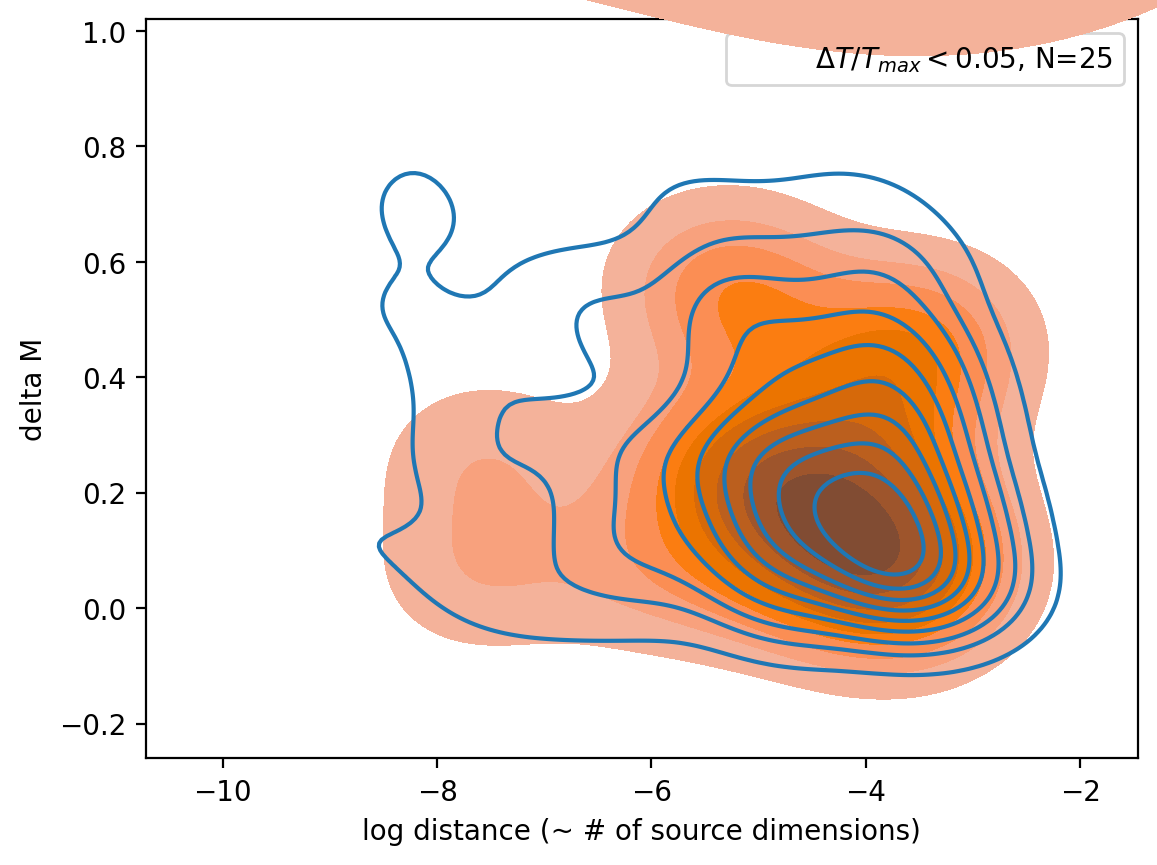

In [560]:
fig, ax = plt.subplots()

sns.kdeplot(
    np.log(distance*1e3 / (10**(3 / 2 * (max_M)+9.05)/3*10**6) ** (1 / 3)), # proxy for strenght of attraction 
    delta_M, # proxy for base phase difference
    ax=ax, 
)


I = delta_recurrence_interval / max_reccurence_interval < phase_locking_threshold
sns.kdeplot(
    np.log(distance[I]*1e3 / (10**(3 / 2 * (max_M[I])+9.05)/3*10**6) ** (1 / 3)), # proxy for strenght of attraction 
    delta_M[I], # proxy for base phase difference 
    label=r"$\Delta T/T_{max} <$" + f"{phase_locking_threshold}, N={sum(I)}",
    fill=True,
    ax=ax,
)

ax.set(xlabel="log distance (~ # of source dimensions)", ylabel="delta M")
ax.legend()

In [518]:
dM_bins = np.linspace(0,2.5,7)
log_distance_bins = np.linspace(-9,0,7)

pairs = np.histogram2d(
    np.log(distance*1e3 / (10**(3 / 2 * (max_M)+9.05)/3*10**6) ** (1 / 3)), # proxy for strenght of attraction 
    delta_M, # proxy for base phase difference
    bins=[log_distance_bins,dM_bins],
    density = True,
)[0].T


I = delta_recurrence_interval / max_reccurence_interval < phase_locking_threshold
phase_locked_pairs = np.histogram2d(
    np.log(distance[I]*1e3 / (10**(3 / 2 * (max_M[I])+9.05)/3*10**6) ** (1 / 3)), # proxy for strenght of attraction 
    delta_M[I], # proxy for base phase difference 
    bins=[log_distance_bins,dM_bins],
    density = True,
)[0].T



/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_80393/4075549485.py:27: RuntimeWarning: invalid value encountered in divide
  np.log10(phase_locked_pairs/pairs),
/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_80393/4075549485.py:27: RuntimeWarning: divide by zero encountered in log10
  np.log10(phase_locked_pairs/pairs),


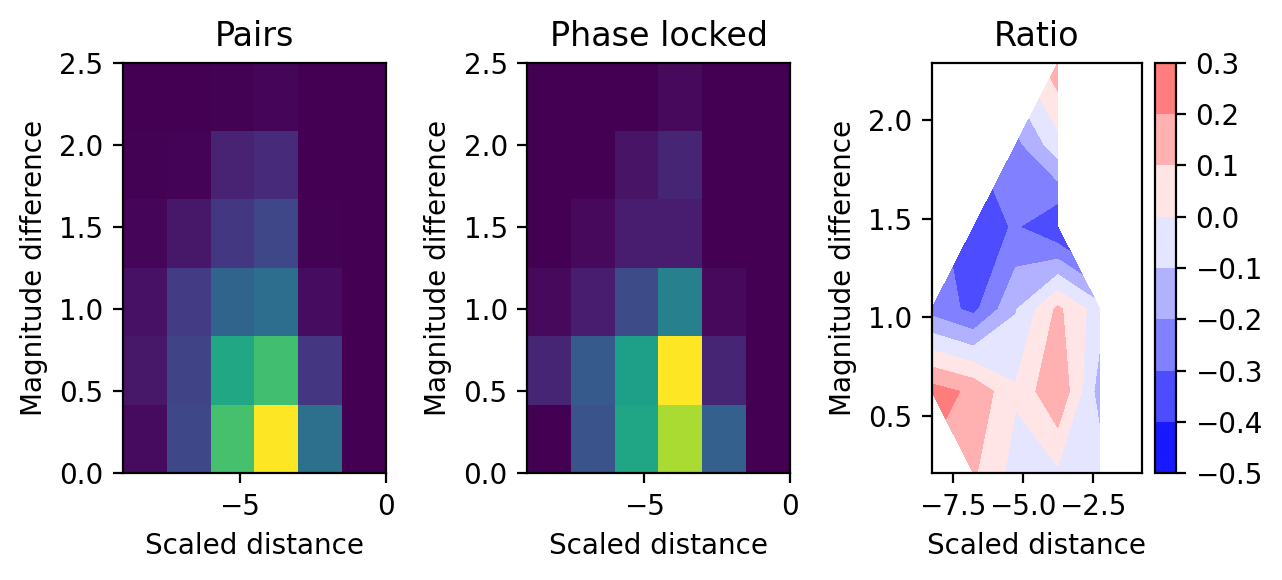

In [519]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(6.5,3))

ax1.imshow(
    pairs,
    origin="lower",
    extent=[log_distance_bins[0], log_distance_bins[-1], dM_bins[0], dM_bins[-1]],
)

ax2.imshow(
    phase_locked_pairs,
    origin="lower",
    extent=[log_distance_bins[0], log_distance_bins[-1], dM_bins[0], dM_bins[-1]],
)



# im = ax3.imshow(
#     np.log10(phase_locked_pairs/pairs),
#     origin="lower",
#     extent=[log_distance_bins[0], log_distance_bins[-1], dM_bins[0], dM_bins[-1]],
#     cmap='seismic',
#     vmin=-1,
#     vmax=1,
# )

im = ax3.contourf(
    np.log10(phase_locked_pairs/pairs),
    origin="lower",
    extent=[log_distance_bins[0], log_distance_bins[-1], dM_bins[0], dM_bins[-1]],
    cmap='seismic',
    vmin=-1,
    vmax=1,
    
)

for ax, title in zip([ax1,ax2,ax3],['Pairs', 'Phase locked', 'Ratio']):
    ax.set(
        aspect='auto',
        xlabel='Scaled distance',
        ylabel='Magnitude difference',
        title=title,
    )
    
fig.colorbar(im)

plt.tight_layout()

As an aside I can look at the cov as a function of proximity...

[Text(0.5, 0, 'Scale distance'), Text(0, 0.5, 'Coefficent of variation')]

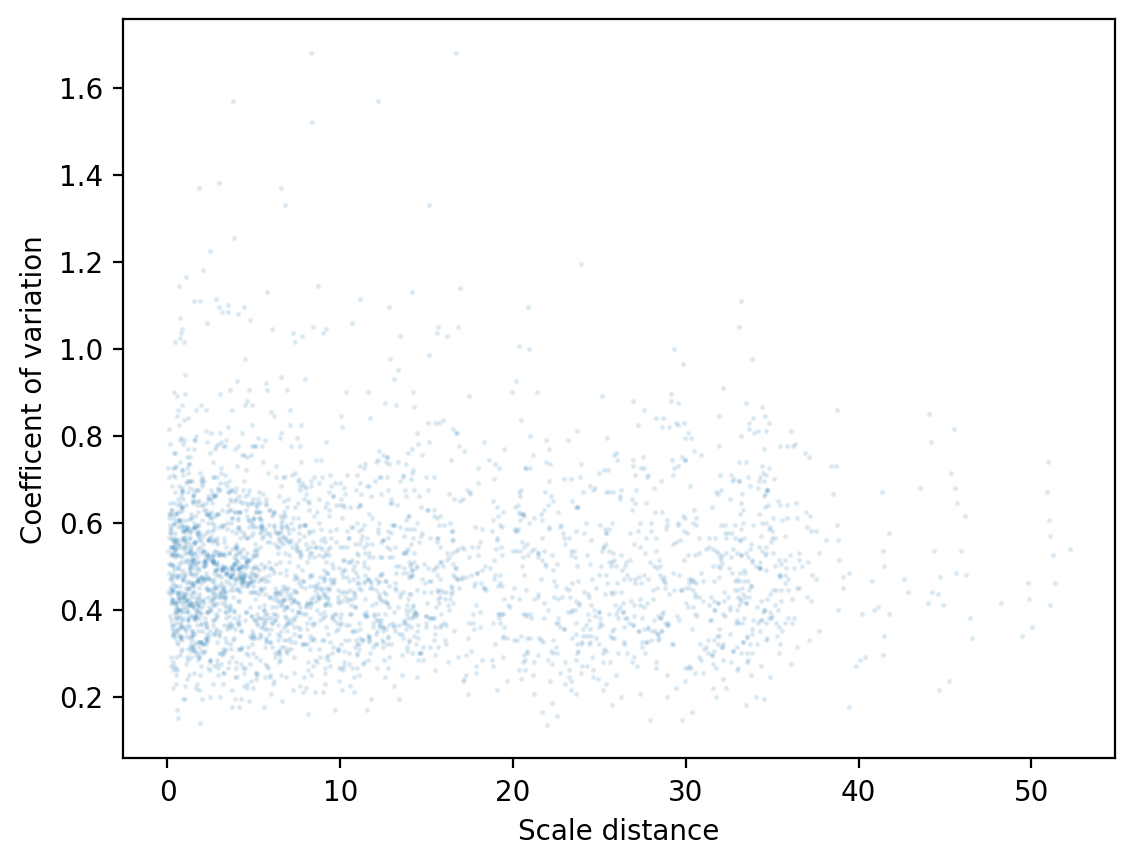

In [532]:
fig, ax = plt.subplots()
ax.scatter(distance, COV, s=1, alpha=0.1)
ax.set(
    xlabel='Scale distance',
    ylabel='Coefficent of variation',
)